<a href="https://colab.research.google.com/github/fariz123133/Visi-Komputer/blob/main/Praktikum_Teknik_Regresi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Praktikum D1

Langkah 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

Langkah 2

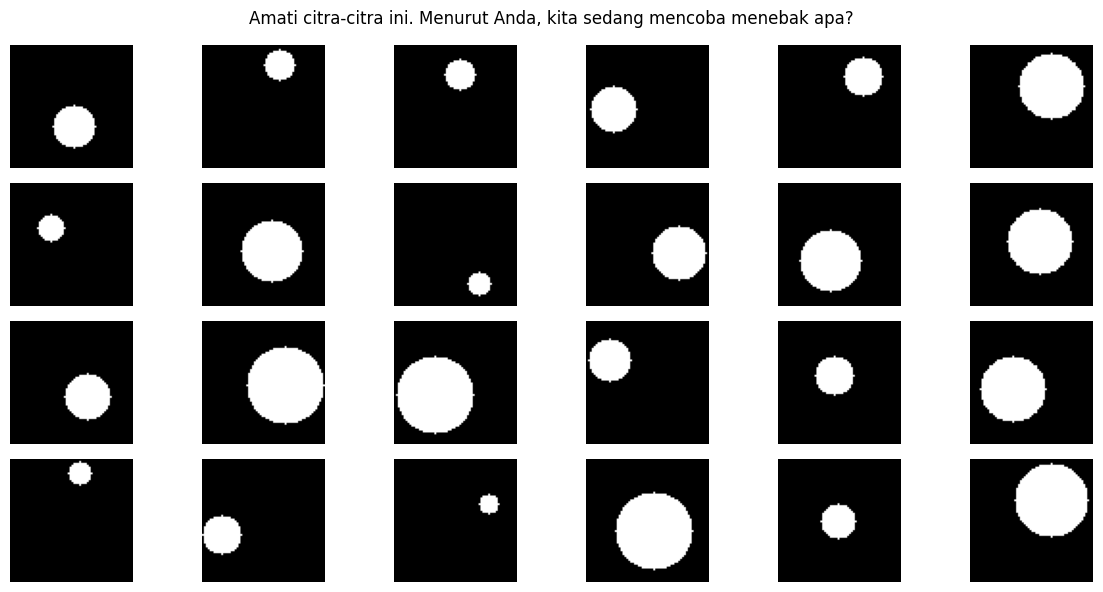

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24

samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


Langkah 3

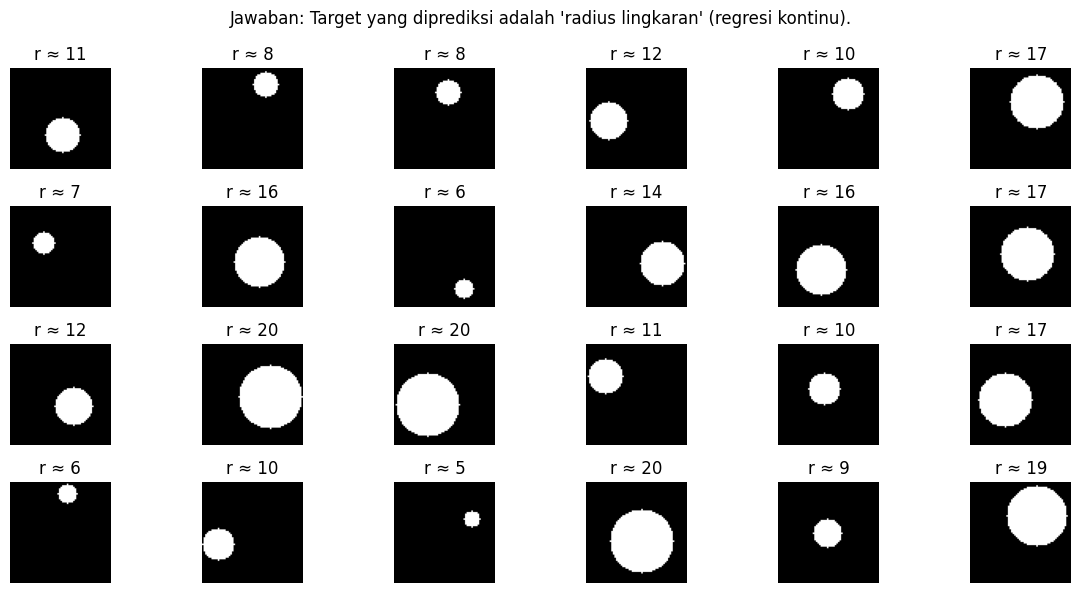

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


Langkah 4

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MAE=0.977 | RMSE=1.209 | R²=0.930


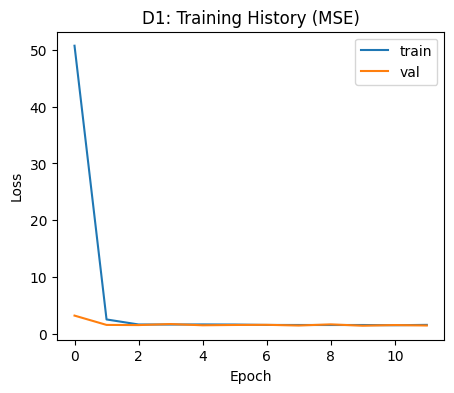

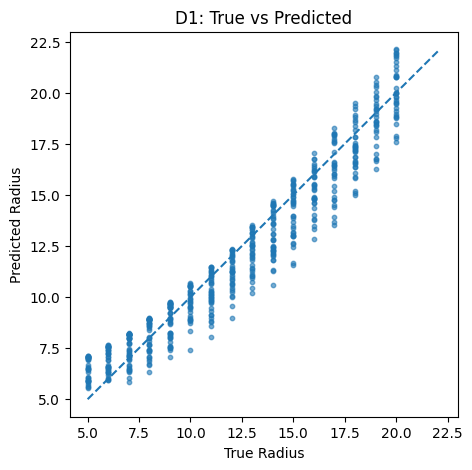

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


Praktikum D2

Langkah 1

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"frdzy1","key":"9aeb87f1c3f2a1bed8ce432f93ba5da0"}'}

Langkah 2

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


Langkah 3

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Langkah 4

Total gambar ditemukan: 23708


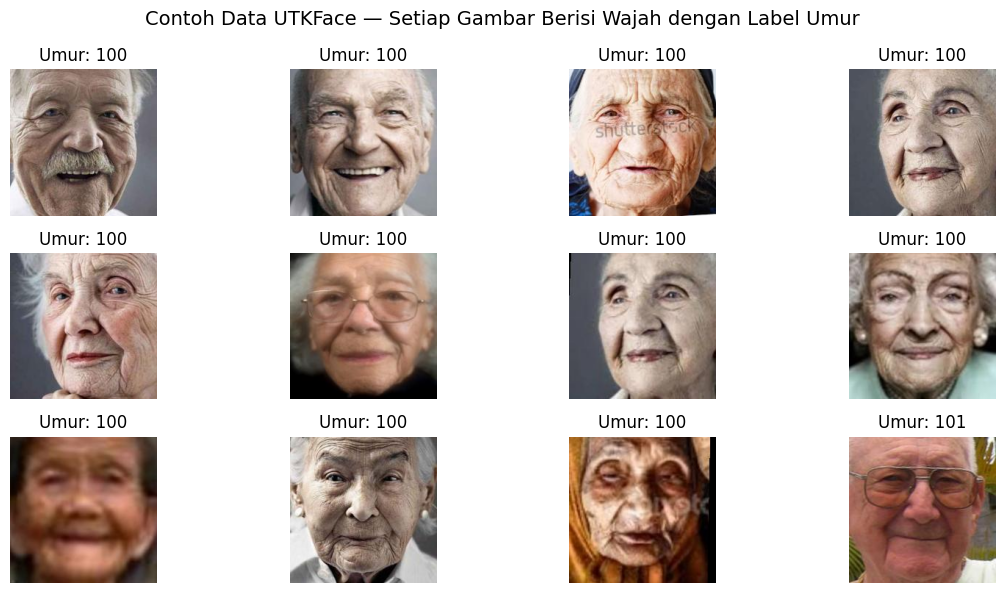

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]): # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")


plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

Langkah 5

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


Langkah 6

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Langkah 7

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - loss: 337.4088 - mae: 13.5161 - val_loss: 162.2138 - val_mae: 9.7803 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 155.8487 - mae: 9.3379 - val_loss: 146.8137 - val_mae: 9.1030 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 144.8184 - mae: 8.9115 - val_loss: 142.4177 - val_mae: 8.9546 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 140.1561 - mae: 8.7324 - val_loss: 138.8275 - val_mae: 8.7575 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 136.7401 - mae: 8.5635 - val_loss: 136.0269 - val_mae: 8.6384 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 135.5705 - mae: 8.5608 - val_loss: 135.6029 - val_mae: 8.5751 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 132.1197 - mae: 8.4384 - val_loss: 140.2457 - va

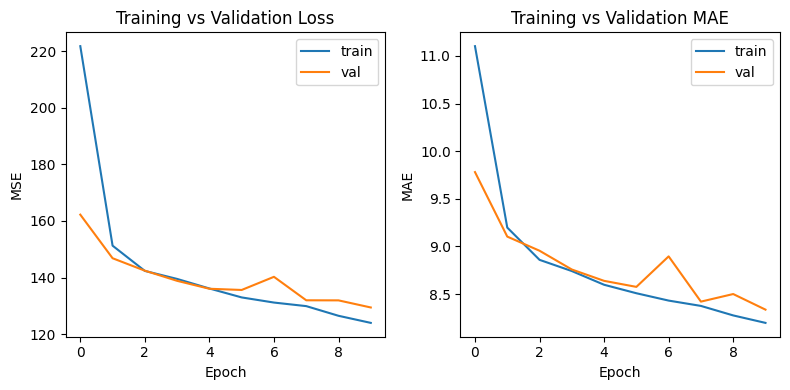

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()


Langkah 8

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - loss: 193.1036 - mae: 10.2294 - val_loss: 138.8536 - val_mae: 8.9730 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 77.7930 - mae: 6.5588 - val_loss: 123.8232 - val_mae: 8.4806 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 51.0909 - mae: 5.3731 - val_loss: 113.5411 - val_mae: 7.9743 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 37.6055 - mae: 4.6796 - val_loss: 107.4767 - val_mae: 7.6559 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 31.0070 - mae: 4.2373 - val_loss: 113.2901 - val_mae: 7.9639 - learning_rate: 1.0000e-04


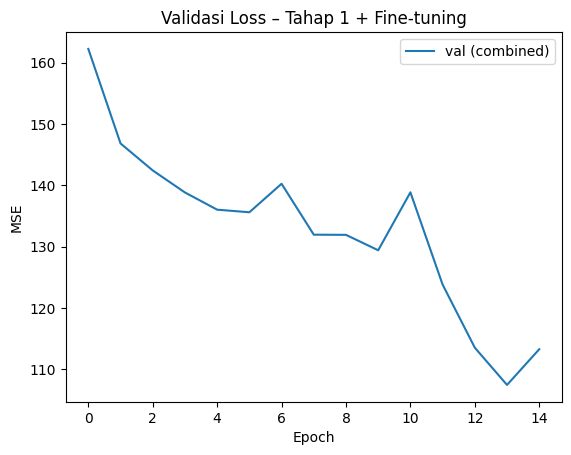

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


Langkah 9

MAE = 7.66 tahun
RMSE = 10.37 tahun
R² = 0.729


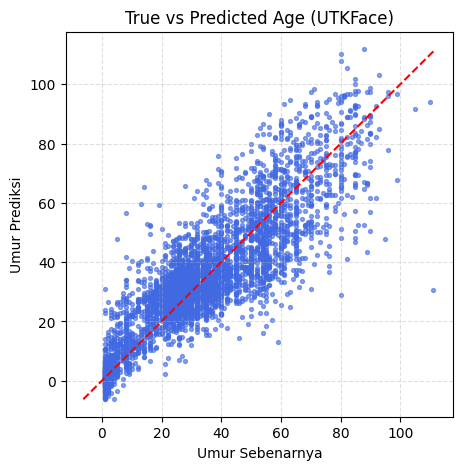

In [ ]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')

lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Langkah 10

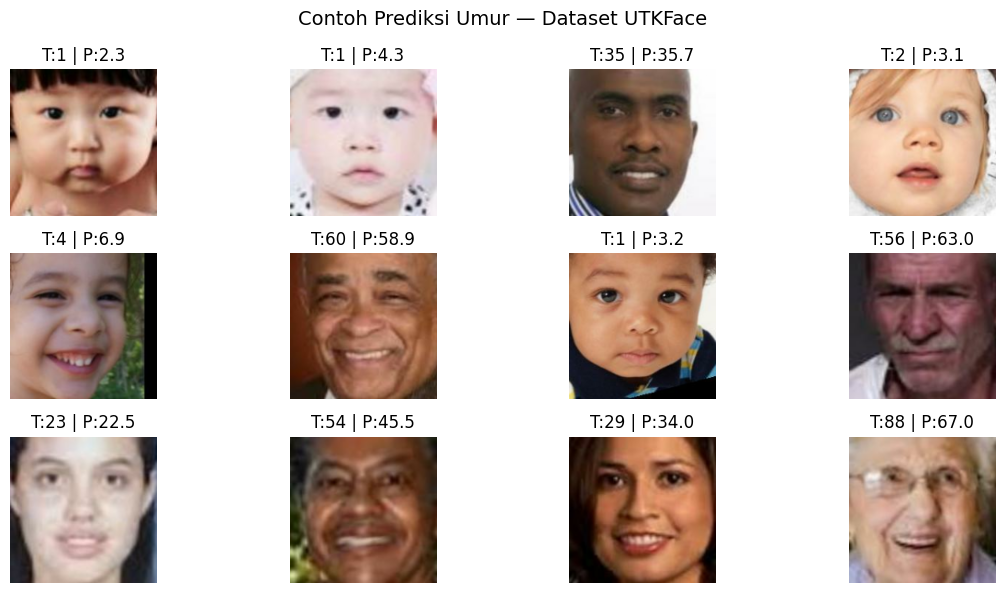

In [ ]:
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Praktikum D3

Langkah 1

In [ ]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("⚠️ kaggle.json belum ditemukan. Upload terlebih dahulu.")


Langkah 2

In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw

print("✅ Dataset Pawpularity berhasil diekstrak.")


✅ Dataset Pawpularity berhasil diekstrak.


Langkah 3

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

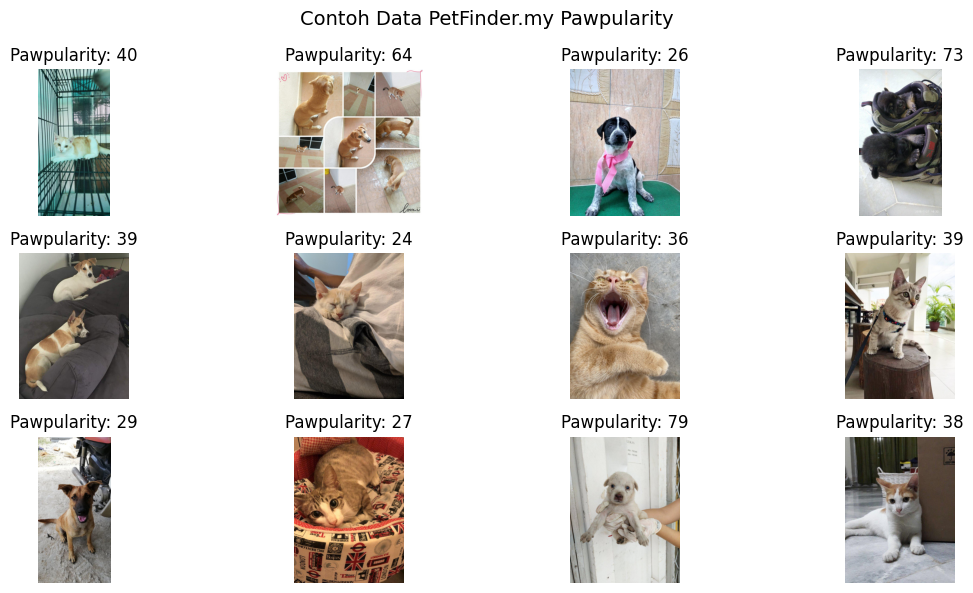

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Langkah 4 — Persiapan Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


Langkah 4 — Membangun Model (EfficientNetB0)

In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Langkah 5 — Melatih Model

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 103s 499ms/step - loss: 876.2271 - mae: 22.3493 - val_loss: 485.5985 - val_mae: 16.0460 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - loss: 436.5819 - mae: 15.3800 - val_loss: 434.9581 - val_mae: 15.4008 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - loss: 386.8934 - mae: 14.4548 - val_loss: 409.8938 - val_mae: 15.0579 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - loss: 384.1186 - mae: 14.5800 - val_loss: 398.0528 - val_mae: 14.8566 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - loss: 380.8621 - mae: 14.5420 - val_loss: 388.4045 - val_mae: 14.2614 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - loss: 360.9659 - mae: 14.0540 - val_loss: 377.4367 - val_mae: 14.1991 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - loss: 341.0255 - mae: 13.7455 - val_

Langkah 6 — Melihat Proses Belajar

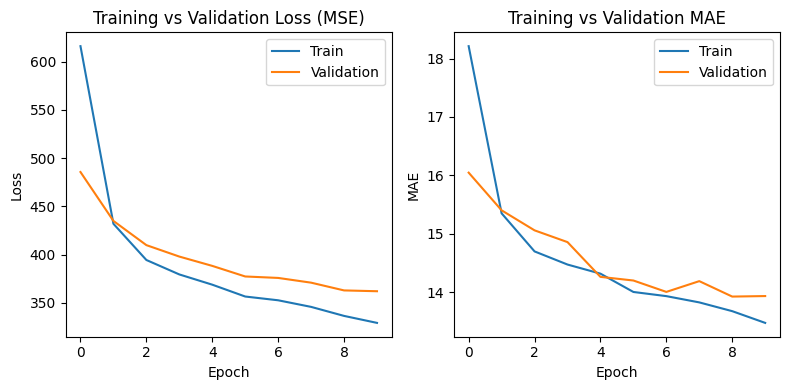

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Langkah 7 — Evaluasi Model

MAE = 13.93
RMSE = 19.03
R²   = 0.181


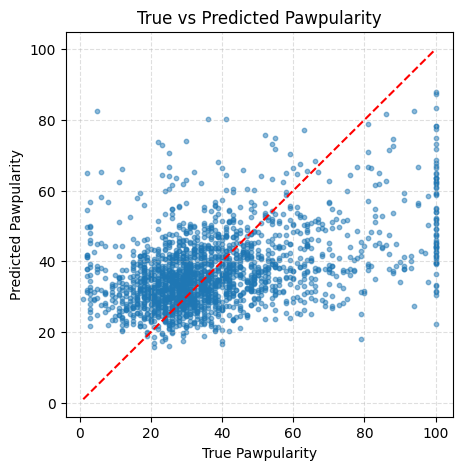

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

# Hitung metrik
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Langkah 8 — Melihat Contoh Prediksi

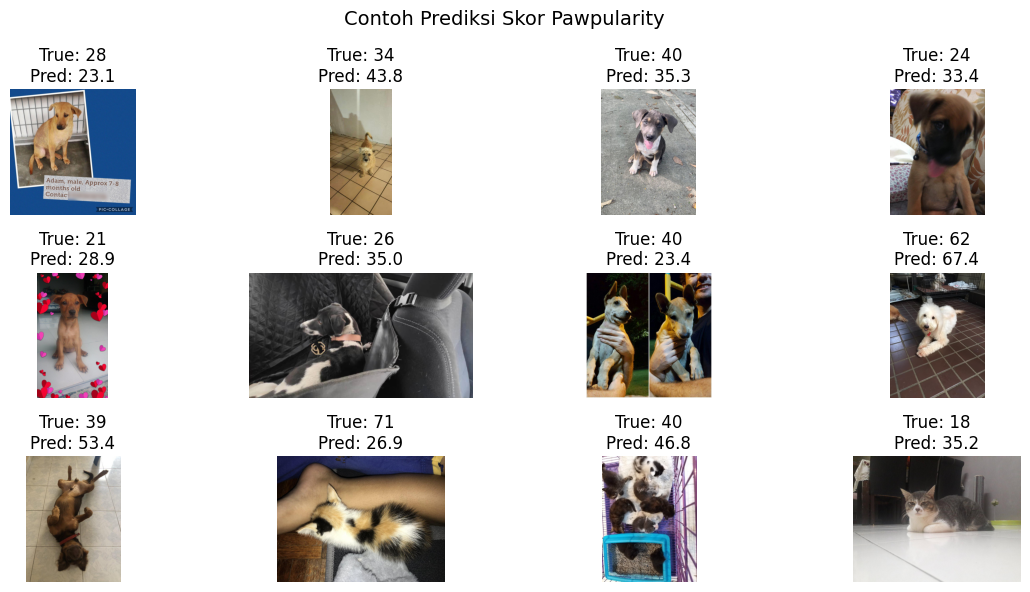

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Tantangan Mini

In [ ]:
# 1. Pastikan Kaggle API sudah aktif seperti di Jobsheet
!pip -q install kaggle

import os, shutil

# Siapkan kredensial kaggle.json jika belum
if not os.path.exists("/root/.kaggle/kaggle.json"):
    from google.colab import files
    files.upload()  # → pilih kaggle.json

    os.makedirs("/root/.kaggle", exist_ok=True)
    shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    print("✅ Kaggle credential siap.")

# 2. Download Pawpularity dataset
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q

# 3. Ekstrak ZIP ke folder /content/paw
!mkdir -p /content/paw
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw

print("✅ Dataset Pawpularity berhasil diekstrak ke /content/paw")
!ls /content/paw


✅ Dataset Pawpularity berhasil diekstrak ke /content/paw
sample_submission.csv  test  test.csv  train  train.csv


In [ ]:
# === Persiapan ulang train_df dan val_df (harus dijalankan sebelum Tantangan 1) ===
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Pastikan path CSV sesuai (D3 sebelumnya)
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

# Split ulang dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi load_image (harus sama dengan yang dipakai di D3 utama)
IMG_SIZE = 224
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Buat dataset validasi ulang agar tidak error
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

print("✅ train_df, val_df, dan val_ds berhasil disiapkan ulang. Lanjutkan Tantangan 1.")


✅ train_df, val_df, dan val_ds berhasil disiapkan ulang. Lanjutkan Tantangan 1.


In [ ]:
# Tantangan 1: Tambahkan data augmentation agar model tidak bosan dengan pola yang sama
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score

# Pastikan variabel val_df, val_ds, train_df, load_image, IMG_SIZE sudah ada dari D3 utama
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE + 20, IMG_SIZE + 20)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    return img, label

train_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

# Gunakan model EfficientNetB0 seperti sebelumnya
base_aug = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet')
base_aug.trainable = False

inputs = tf.keras.Input((IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_aug(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_aug = tf.keras.Model(inputs, outputs)
model_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_aug = model_aug.fit(train_aug, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

# Evaluasi
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model_aug.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"(Augmented) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 122s 574ms/step - loss: 809.8207 - mae: 21.3345 - val_loss: 482.0396 - val_mae: 16.2108 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 263ms/step - loss: 434.1844 - mae: 15.3538 - val_loss: 435.8466 - val_mae: 15.3964 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 263ms/step - loss: 402.9653 - mae: 14.9196 - val_loss: 409.7405 - val_mae: 14.7327 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - loss: 384.8893 - mae: 14.5349 - val_loss: 393.8699 - val_mae: 14.6984 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - loss: 370.6297 - mae: 14.2376 - val_loss: 383.7249 - val_mae: 14.2435 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 224ms/step - loss: 369.0538 - mae: 14.3116 - val_loss: 378.1116 - val_mae: 14.2383 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 82

In [ ]:
# ✅ Setup variabel dasar untuk D3 Regression Pawpularity (wajib sebelum Tantangan 2)
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Ukuran gambar fix sesuai Jobsheet D3
IMG_SIZE = 224

# Load ulang CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

# Split ulang dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Re-define load_image
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# DataLoader untuk training dan validasi
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print("✅ IMG_SIZE, train_df, val_df, train_ds, dan val_ds sudah siap. Jalankan Tantangan 2 sekarang.")


✅ IMG_SIZE, train_df, val_df, train_ds, dan val_ds sudah siap. Jalankan Tantangan 2 sekarang.


In [ ]:
# Tantangan 2: Ganti model dengan EfficientNetB3 / ResNet50
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

# Gunakan model lebih besar: EfficientNetB3
base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history_b3 = model_b3.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=cb, verbose=1)

# Evaluasi performa model
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred_b3 = np.concatenate([model_b3.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred_b3)
rmse = np.sqrt(np.mean((y_true - y_pred_b3)**2))
r2 = r2_score(y_true, y_pred_b3)
print(f"(EfficientNetB3) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

Epoch 1/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 743ms/step - loss: 885.0291 - mae: 22.3832 - val_loss: 489.0393 - val_mae: 16.1952 - learning_rate: 0.0010
Epoch 2/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - loss: 446.5986 - mae: 15.7012 - val_loss: 425.7974 - val_mae: 14.9890 - learning_rate: 0.0010
Epoch 3/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 55s 291ms/step - loss: 396.9951 - mae: 14.7976 - val_loss: 391.4953 - val_mae: 14.7330 - learning_rate: 0.0010
Epoch 4/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 292ms/step - loss: 372.5914 - mae: 14.3553 - val_loss: 378.8078 - val_mae: 14.4461 - learning_rate: 0.0010
Epoch 5/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - loss: 353.8749 - mae: 14.1074 - val_loss: 371.3678 - val_mae: 14.2489 - learning_rate: 0.0010
Epoch 6/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 272ms/step - loss: 343.5545 - mae: 13.8384 - val_loss: 366.7603 - val_mae: 14.1498 - learning_rate: 0.0010
Epoch 7/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 259ms/step - loss: 340.0359 - mae: 13.7438 - val_loss: 3

In [ ]:
# Tantangan Mini 3 Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

# Gunakan model terbaik yang sudah dilatih
model_to_use = (
    model_b3 if 'model_b3' in globals()
    else model_aug if 'model_aug' in globals()
    else model
)

# Bagi subset validasi menjadi dua kelompok simulasi
val_paths = np.array(val_df['path'])
val_paths = shuffle(val_paths, random_state=42)
half = len(val_paths) // 2
dog_files = val_paths[:half]
cat_files = val_paths[half:]

def load_predict_list(paths, model):
    imgs = []
    for p in paths:
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        imgs.append(img)
    imgs = tf.stack(imgs)
    preds = model.predict(imgs, verbose=0).ravel()
    return preds

# Prediksi dua kelompok simulasi
dog_preds = load_predict_list(dog_files[:200], model_to_use)
cat_preds = load_predict_list(cat_files[:200], model_to_use)

# Analisis rata-rata skor prediksi
dog_mean = np.mean(dog_preds)
cat_mean = np.mean(cat_preds)

print("Analisis Rata-rata Skor:")
print(f"Kelompok 1 ('Dog' simulasi) rata-rata prediksi = {dog_mean:.2f}")
print(f"Kelompok 2 ('Cat' simulasi) rata-rata prediksi = {cat_mean:.2f}")

if dog_mean > cat_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).")
elif cat_mean > dog_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 2 (kucing simulasi).")
else:
    print("=> Model seimbang antara kedua kelompok.")

# Analisis akurasi (MAE per kelompok)
val_df['species'] = np.random.choice(['dog', 'cat'], size=len(val_df))
y_pred = np.concatenate([
    model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds
])
val_df['predicted_pawpularity'] = y_pred

dogs_df = val_df[val_df['species'] == 'dog']
cats_df = val_df[val_df['species'] == 'cat']

if not dogs_df.empty and not cats_df.empty:
    mae_dogs = mean_absolute_error(dogs_df['Pawpularity'], dogs_df['predicted_pawpularity'])
    mae_cats = mean_absolute_error(cats_df['Pawpularity'], cats_df['predicted_pawpularity'])

    print("\nAnalisis Akurasi (MAE per kelompok):")
    print(f"MAE untuk Anjing: {mae_dogs:.3f}")
    print(f"MAE untuk Kucing: {mae_cats:.3f}")

    if abs(mae_dogs - mae_cats) > 1.0:
        print("Model menunjukkan potensi bias performa.")
        if mae_dogs < mae_cats:
            print("=> Model lebih akurat untuk foto anjing.")
        else:
            print("=> Model lebih akurat untuk foto kucing.")
    else:
        print("=> Performa model relatif seimbang antara anjing dan kucing.")
else:
    print("=> Tidak cukup data untuk membandingkan performa anjing vs kucing.")

Analisis Rata-rata Skor:
Kelompok 1 ('Dog' simulasi) rata-rata prediksi = 38.49
Kelompok 2 ('Cat' simulasi) rata-rata prediksi = 37.51
=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).

Analisis Akurasi (MAE per kelompok):
MAE untuk Anjing: 14.047
MAE untuk Kucing: 13.643
=> Performa model relatif seimbang antara anjing dan kucing.


In [ ]:
# Tantangan 4: Gabungkan fitur non-visual (brightness) dengan hasil CNN
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Hitung tingkat kecerahan (brightness rata-rata) untuk setiap gambar
def calc_brightness(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

brightness_vals = np.array([calc_brightness(p) for p in val_df['path']])

# Prediksi dari model CNN (gunakan model terakhir yang dilatih)
cnn_preds = np.concatenate([model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds])
true_vals = val_df['Pawpularity'].values

# Gabungkan hasil CNN dan brightness dalam model regresi linear
X = np.column_stack([cnn_preds, brightness_vals])
reg = LinearRegression().fit(X, true_vals)
pred_final = reg.predict(X)

# Evaluasi hasil kombinasi
mae = mean_absolute_error(true_vals, pred_final)
rmse = np.sqrt(np.mean((true_vals - pred_final)**2))
r2 = r2_score(true_vals, pred_final)

print(f"(CNN + Brightness) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

(CNN + Brightness) MAE=13.91 | RMSE=18.86 | R²=0.195


Penugasan

Upload foto wajah kamu (jpg/png):


Saving WhatsApp Image 2025-10-16 at 21.19.03.jpeg to WhatsApp Image 2025-10-16 at 21.19.03 (1).jpeg
Pakai model default


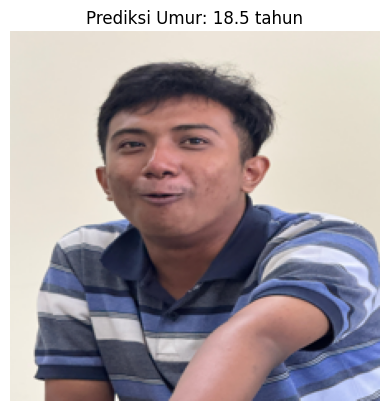

In [ ]:
# Penugasan 3: Prediksi Umur (foto pribadi)
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

print("Upload foto wajah kamu (jpg/png):")
data = files.upload()

# pilih model yang udah dilatih
try:
  modelku = model_aug
  print("Pakai model_aug")
except:
  try:
    modelku = model
    print("Pakai model default")
  except:
    raise Exception("Model belum dilatih! Jalankan D2 dulu.")

for f in data.keys():
  img = Image.open(f).convert('RGB')
  img = img.resize((IMG_SIZE, IMG_SIZE))
  arr = np.array(img) / 255.0
  arr = np.expand_dims(arr, 0)

  pred = modelku.predict(arr, verbose=0)[0][0]
  plt.imshow(img)
  plt.title(f"Prediksi Umur: {pred:.1f} tahun")
  plt.axis('off')
  plt.show()

Upload foto hewan kamu (anjing/kucing):


Saving cats-2766600_1280.jpg to cats-2766600_1280 (1).jpg
Pakai model default (mungkin kurang akurat)


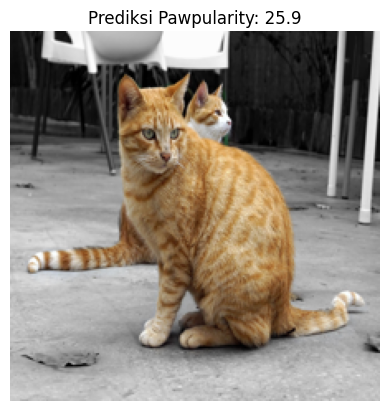

In [ ]:
# Penugasan 4: Prediksi Pawpularity (foto hewan)
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

print("Upload foto hewan kamu (anjing/kucing):")
data = files.upload()

# pilih model mana aja yang ada
if 'model_b3' in globals():
  modelnya = model_b3
  print("Pakai EfficientNetB3")
elif 'model_aug' in globals():
  modelnya = model_aug
  print("Pakai model_aug")
else:
  modelnya = model
  print("Pakai model default (mungkin kurang akurat)")

for f in data.keys():
  img = Image.open(f).convert('RGB')
  img = img.resize((IMG_SIZE, IMG_SIZE))
  arr = np.array(img).astype(np.float32) / 255.0
  arr = np.expand_dims(arr, axis=0)

  skor = modelnya.predict(arr, verbose=0)[0][0]
  plt.imshow(img)
  plt.title(f"Prediksi Pawpularity: {skor:.1f}")
  plt.axis('off')
  plt.show()